# Setup
Firstly, we need to setup the environment by mounting Google Drive, importing the required libraries and fixing the random seed for our experiments' reproducibility.

The path should be set to where this notebook file is, and the dataset should be present in the same folder. 

In [ ]:
gdrive = False

In [ ]:
if(gdrive):
    from google.colab import drive
    drive.mount('/gdrive')
    path = "/gdrive/My Drive/Colab Notebooks/AN2DL/Homework1"
    %cd /gdrive/My Drive/Colab Notebooks/AN2DL/Homework1
else:
    path = os.getcwd()
    print(str(path))

C:\Users\zheng\Documents\Uni\Magistrale\ANNDL\22-23\Homework1\Playground


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13374501323155411370
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5738397696
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9919746650561388401
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2d:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
# Fix random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Data splitting
Now the dataset file should be unzipped and split into two parts: a training folder and a validation folder. (Current split ratio: 19:1)

Two data splitting modes are provided here:
- make a random split using the package split-folders,
- make a regular split using the function we defined below.

In [ ]:
# Set to True to use the random seed for data splitting
split_folder = False
random_split = True

In [ ]:
# Random split: the operation is based on the chosen random seed
# Regular split: the operation selects a validation sample per 20 images

if(split_folder):
    %cd '/kaggle/input/d/kodai7/an2dl-homework1-dataset2/dataset2'

if(split_folder and random_split):

  cwd = os.getcwd()
  cwd

  !pip install split-folders

  import splitfolders
  splitfolders.ratio("training", output="output", seed=seed, ratio=(.8, .1, .1), group_prefix=None)
  print("Random split completed")

elif(split_folder):

  import glob
  import shutil

  path = dataset_dir_path
  os.chdir(path)
  cwd = os.getcwd()
  cwd

  os.makedirs("validation", exist_ok=True)

  i = 0
  for file in glob.glob("training/*/*.jpg", recursive=True):
    if i == 20:
        old_path = os.path.join(cwd, str(file))
        new_path = old_path.replace("training", "validation")
        print("Image: " + new_path)
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        shutil.move(old_path, new_path)
        i = 0
        continue
    i += 1
  print("Regular split completed")


In [ ]:
# Set working paths
# default random_split

if((split_folder and random_split) or not split_folder):
    data_dir = os.path.join(path, 'dataset2')
    dataset_dir = os.path.join(data_dir, 'output')
    training_dir = os.path.join(dataset_dir, 'train')
    validation_dir = os.path.join(dataset_dir, 'val')
    test_dir = os.path.join(dataset_dir, 'test')
elif(split_folder):
    dataset_dir = cwd
    training_dir = os.path.join(dataset_dir, 'training')
    validation_dir = os.path.join(dataset_dir, 'validation')
    test_dir = os.path.join(dataset_dir, 'test')    

# Mode selection
There are different available options for the model: it can be a basic convolutional neural network or based on a pre-trained one.

The pre-trained models that we tried out are MobileNetV2, ResNet50V2, VGG19, EfficientNetB7.

In transfer learning mode, the parameters of the supernet are freezed temporarily.

In [ ]:
# Params: [Baseline, Mobilenet, Resnet, VGG, Efficientnet]
mode = 'VGG'
transfer_learning = True

# Data pre-processing
In this part, data preprocessing is done with the corresponding preprocessing function or with the rescale factor.

Data augmentation options are also available.

In [ ]:
# Import the correct preprocessing function for pre-trained models
if mode == 'Mobilenet':
  from tensorflow.keras.applications.mobilenet import preprocess_input

if mode == 'Resnet':
  from tensorflow.keras.applications.resnet50v2 import preprocess_input

if mode == 'Efficientnet':
  from tensorflow.keras.applications.efficientnet import preprocess_input

if mode == 'VGG':
  from tensorflow.keras.applications.vgg19 import preprocess_input

In [ ]:
# Set batch size
batch_size = 64

In [ ]:
# Set to True to apply data augmentation methods
data_augmentation = True
read_data_as_array = True

In [ ]:
if(read_data_as_array):
    imgs_others = []
    class_img_others_pahts = os.walk(training_dir + '/Others/')
    for img_paths in class_img_others_pahts:
        for img_path in img_paths[2]:
            # load the image
            image = Image.open(training_dir + '/Others/'+img_path)
            # convert image to numpy array
            data = np.asarray(image)
            imgs_others.append(data)
    imgs_others_y = np.zeros(shape=(1, len(imgs_others)), dtype=int)[0]
    
    imgs_sp1 = []
    class_img_sp1_pahts = os.walk(training_dir + '/Species1/')
    for img_paths in class_img_sp1_pahts:
        for img_path in img_paths[2]:
            # load the image
            image = Image.open(training_dir + '/Species1/'+img_path)
            # convert image to numpy array
            data = np.asarray(image)
            imgs_sp1.append(data)
    imgs_sp1_y = np.ones(shape=(1, len(imgs_sp1)), dtype=int)[0]
    
    # TRAINING UNDER SAMPLING
    mask_others = np.full(len(imgs_others), False)
    mask_others[:len(imgs_sp1)] = True
    np.random.shuffle(mask_others)
    imgs_others = np.array(imgs_others)
    imgs_others_undersampled = imgs_others[mask_others]
    imgs_others_undersampled_y = np.zeros(shape=(1, len(imgs_others_undersampled)), dtype=int)[0]
    
#     imgs_x, imgs_y are after undersampling
    imgs_x = np.concatenate((imgs_others_undersampled, imgs_sp1))
    imgs_y = np.concatenate((imgs_others_undersampled_y, imgs_sp1_y), dtype=int)

    train_imgs_x, valid_imgs_x, train_imgs_y, valid_imgs_y = train_test_split(imgs_x, imgs_y, test_size=0.2, random_state=42)

In [ ]:
train_imgs_x.shape, train_imgs_y.shape, valid_imgs_x.shape, valid_imgs_y.shape

((236, 96, 96, 3), (236,), (60, 96, 96, 3), (60,))

In [ ]:
# Define augmented images generator

import albumentations as alb
from tensorflow.keras.utils import Sequence

class AugmentDataGenerator(Sequence):
    def __init__(self, datagen, augment=None):
        self.datagen = datagen
        if augment is None:
            self.augment = alb.Compose([])
        else:
            self.augment = augment
    
    def __len__(self):
        return len(self.datagen)
    
    def __getitem__(self, x):
        images, *rest = self.datagen[x]
        augmented = []
        for image in images:
            image = self.augment(image=image)['image']
            augmented.append(image)
        return (np.array(augmented), *rest)

In [ ]:
# Load data with ImageDataGenerator
# Other available parameters: width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.15, rotation_range = 20

from tensorflow.keras.preprocessing.image import ImageDataGenerator

if(data_augmentation):
    if(mode == 'Baseline'):
        train_data_gen = ImageDataGenerator(
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = "reflect",
            rescale = 1/255.
        )

        val_data_gen = ImageDataGenerator(
            rescale = 1/255.)

        test_data_gen = ImageDataGenerator(
            rescale = 1/255.)

        print("Data augmentation and rescaling completed")
    
    else:
        # train_data_gen = ImageDataGenerator(
        #     rotation_range = 90,
        #     zoom_range = 0.2,
        #     width_shift_range = 0.2,
        #     height_shift_range = 0.2,
        #     horizontal_flip = True,
        #     vertical_flip = True,
        #     fill_mode = "reflect",
        #     preprocessing_function = preprocess_input
        # )

        train_data_gen = ImageDataGenerator(
            preprocessing_function = preprocess_input)

        val_data_gen = ImageDataGenerator(
            preprocessing_function = preprocess_input)

        test_data_gen = ImageDataGenerator(
            preprocessing_function = preprocess_input)

        print("Data augmentation and input preprocessing completed")
        
else:

    if(mode == 'Baseline'):
      train_data_gen = ImageDataGenerator(
          rescale = 1/255.)
      val_data_gen = ImageDataGenerator(
          rescale = 1/255.)
      test_data_gen = ImageDataGenerator(
          rescale = 1/255.)
      print("Rescaling completed")

    else:
      train_data_gen = ImageDataGenerator(
          preprocessing_function = preprocess_input)
      val_data_gen = ImageDataGenerator(
          preprocessing_function = preprocess_input)
      test_data_gen = ImageDataGenerator(
          preprocessing_function = preprocess_input)
      print("Input preprocessing completed")

        
if (read_data_as_array):
    train_gen = train_data_gen.flow(
        train_imgs_x,
        train_imgs_y,
        batch_size = batch_size,
        shuffle = True,
        seed = seed
    )

    val_gen = val_data_gen.flow(
        valid_imgs_x,
        valid_imgs_y,
        batch_size = batch_size,
        shuffle = False,
        seed = seed
    )

#     test_gen = test_data_gen.flow(
#         train_imgs_x,
#         train_imgs_y,
#         target_size = (96,96),
#         color_mode = 'rgb',
#         classes = None,
#         class_mode = 'binary',
#         batch_size = batch_size,
#         shuffle = False,
#         seed = seed
#     )
    
else:
    train_gen = train_data_gen.flow_from_directory(
        directory = training_dir,
        target_size = (96,96),
        color_mode = 'rgb',
        classes = None,
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True,
        seed = seed
    )

    val_gen = val_data_gen.flow_from_directory(
        directory = validation_dir,
        target_size = (96,96),
        color_mode = 'rgb',
        classes = None,
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = False,
        seed = seed
    )

    test_gen = test_data_gen.flow_from_directory(
        directory = test_dir,
        target_size = (96,96),
        color_mode = 'rgb',
        classes = None,
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = False,
        seed = seed
    )

Data augmentation and input preprocessing completed


In [ ]:
if(data_augmentation):
    train_gen = AugmentDataGenerator(train_gen, alb.Compose([
        alb.HorizontalFlip(),
        alb.VerticalFlip(),
        alb.Transpose(),
        alb.CoarseDropout(),
        alb.RandomBrightnessContrast(),
        alb.GaussNoise(),
        alb.SafeRotate(limit=20),
        alb.OneOf([
            alb.GridDistortion(),
            alb.OpticalDistortion()
        ], p=0.3)
    ]))
    
    print("Data augmentation applied")

Data augmentation applied


## Get some samples

In [ ]:
# def get_next_batch(generator):
#   batch = next(generator)

#   image = batch[0]
#   target = batch[1]

#   print("(Input) image shape:", image.shape)
#   print("Target shape:",target.shape)

#   # Visualize only the first sample
#   image = image[0]
#   target = target[0]
#   target_idx = np.argmax(target)
#   print()
#   print("Categorical label:", target)
#   print("Label:", target_idx)
#   print("Class name:", labels[target_idx])
#   fig = plt.figure(figsize=(6, 4))
#   plt.imshow(np.uint8(image))

#   return batch

In [ ]:
# # Get a sample from dataset and show info
# _ = get_next_batch(train_gen)

# Hyperparameters setting
In this part, the hyperparameters of the model are defining.

In [ ]:
# Fix input shape and number of epochs
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
# Define loss
loss = tfk.losses.BinaryCrossentropy()

# Define learning rate
lr = 3e-4

# Define optimizer for regularization
optimizer = tfk.optimizers.Adam(learning_rate = lr)

# Define metrics for evaluation
# metrics = [tf.keras.metrics.Precision()]
metrics = ['accuracy']

# Model structure
According to the chosen mode, the corresponding model structure is loaded.

## Basic CNN model

In [ ]:
# Use base CNN model
if(mode == 'Baseline' or False):
  model = tfk.Sequential()

  # Input layer
  model.add(tfkl.Input(shape=input_shape, name='Input'))

  # Convolution + Pooling
  model.add(tfkl.Conv2D(
      filters=16,
      kernel_size=(3, 3),
      strides=(1, 1),
      padding='same',
      activation='relu',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))
  model.add(tfkl.BatchNormalization())
  model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))

  model.add(tfkl.Conv2D(
      filters=32,
      kernel_size=(3, 3),
      strides=(1, 1),
      padding='same',
      activation='relu',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))
  model.add(tfkl.BatchNormalization())
  model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))

  model.add(tfkl.Conv2D(
      filters=64,
      kernel_size=(3, 3),
      strides=(1, 1),
      padding='same',
      activation='relu',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))
  model.add(tfkl.BatchNormalization())
  model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))

  # Global average pooling
  model.add(tfkl.Flatten(name='Flatten'))

  # Dropout layer
  model.add(tfkl.Dropout(0.4, seed=seed))

  # Linear layer with ReLU activation
  model.add(tfkl.Dense(
      units=64,
      activation='relu',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))

  # Dropout layer
  model.add(tfkl.Dropout(0.4, seed=seed))

  # Output layer
  model.add(tfkl.Dense(
      units=1,
      activation='sigmoid',
      kernel_initializer = tfk.initializers.GlorotUniform(seed),
      name='Output'
  ))

In [ ]:
# Use base CNN model
if(mode == 'Baseline'):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=1, activation='sigmoid', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

## Supernet: MobileNetV2

In [ ]:
# Use MobileNetV2
if(mode == 'Mobilenet'):
  supernet = tfk.applications.MobileNetV2(
      weights='imagenet',
      include_top=False,
      input_shape=input_shape)

  model = tfk.Sequential()
  model.add(supernet)

  model.add(tfkl.AveragePooling2D(pool_size=(2, 2)))
  model.add(tfkl.Flatten())

  model.add(tfkl.Dense(
      units=128,
      activation='relu',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))
  model.add(tfkl.Dropout(0.5, seed=seed))
  model.add(tfkl.Dense(
      units=1,
      activation='sigmoid',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))
#   model.add(tfkl.Flatten(name='FlattenOutput'))

## Supernet: ResNet50V2

In [ ]:
# Use ResNet50V2
if(mode == 'Resnet'):
  supernet = tfk.applications.ResNet50V2(
    include_top = False,
    weights = 'imagenet',
    input_shape = input_shape)

  model = tfk.Sequential()
  model.add(supernet)
  model.add(tfkl.Flatten())
  model.add(tfkl.Dropout(0.3, seed=seed))
  model.add(tfkl.Dense(
      units = 256,
      activation = 'relu',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))
  model.add(tfkl.Dropout(0.5, seed=seed))
  model.add(tfkl.Dense(
      units = 14,
      activation = 'softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))

## Supernet: VGG19

In [ ]:
if(mode == 'VGG'):
  supernet = tfk.applications.VGG19(
    include_top = False,
    weights = "imagenet",
    input_shape = input_shape)
  
  model = tf.keras.Sequential()
  model.add(supernet)
  model.add(tfkl.Flatten())
  model.add(tfkl.Dropout(0.4, seed=seed))

  model.add(tfkl.Dense(
    units = 96,
    activation = 'relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)))
  
  model.add(tfkl.Dropout(0.4, seed=seed))
  
  model.add(tfkl.Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)))

## Supernet: EfficientNetB7

In [ ]:
# Use EfficientNetB7
if(mode == 'Efficientnet'):
  supernet = tf.keras.applications.EfficientNetB7(
      weights='imagenet',
      include_top=False,
      input_shape=input_shape)

  model = tf.keras.Sequential()
  model.add(supernet)
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.add(tfkl.Dense(
      units=128,
      activation='relu',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))
  model.add(tfkl.Dropout(0.5, seed=seed))
  model.add(tfkl.Dense(
      units=14,
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
  ))

## Transfer learning setting

In [ ]:
# Freeze the supernet if it is in transfer learning mode
if(transfer_learning):
    supernet.trainable = False

## Model summary and compilation

In [ ]:
# Show model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 96)                442464    
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 20,466,945
Trainable params: 442,561
Non-t

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

# Fine Tuning
If transfer learning was done, we can improve the performance by unfreezing some layers of the pre-trained model.

In [ ]:
# Load and show the transfer learning model
# model = tfk.models.load_model('TLModel')
# model.summary()

In [ ]:
# Unfreeze some layers and show the result
for i, layer in enumerate(model.get_layer('vgg19').layers[15:]):
  layer.trainable = True

for i, layer in enumerate(model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                             

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

# Checkpoint and Early stopping settings
Early stopping options can be activated to limit model overfitting.

There is possibility to save checkpoints during the training, in order to keep track of the performance and to get more choices of the final model.


## Custom callback function

In [ ]:
class UnfreezeCallback(tf.keras.callbacks.Callback):
    def __init__(self, optimizer, loss, metrics, n_epochs=0, layer=''):
        super().__init__()
        self.n_epochs = n_epochs
        self.layer = layer
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics

    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.n_epochs:
            self.model.get_layer(self.layer).trainable = True
            for i, layer in enumerate(model.get_layer(self.layer).layers[:10]):
                layer.trainable = True
            self.model.compile(
                optimizer=self.optimizer,
                loss=self.loss,
                metrics=self.metrics
            )
            print("Unfreezed all layers at epoch {}".format(epoch))
            for i, layer in enumerate(model.get_layer(self.layer).layers):
                print(i, layer.name, layer.trainable)

In [ ]:
from datetime import datetime

# %cd /kaggle/working

# Utility function to create folders and callbacks for training
def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')
    print(str(now))

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

    # Model checkpoint
    ckpt_dir = os.path.join(exp_dir, 'base_ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
#     # By default shows losses and metrics for both training and validation
#     tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
#                                                profile_batch=0,
#                                                histogram_freq=1)  # if > 0 (epochs) shows weights histograms
#     callbacks.append(tb_callback)

    # Early Stopping

    # # Monitoring parameter: validation loss
    # monitor = 'val_loss'
  
    # # Number of epochs after that the training stops, if there are no improvements
    # patience = 20

    # es_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)
    # callbacks.append(es_callback)

#     # Unfreeze layers
    # uf_callback = UnfreezeCallback(n_epochs=10, layer='vgg19', optimizer=optimizer, loss=loss, metrics=metrics)
    # callbacks.append(uf_callback)

    return callbacks

# Model fitting
The chosen model is fit on the training dataset.

In [ ]:
callbacks = create_folders_and_callbacks(model_name = mode)
callbacks

Nov18_20-45-18


In [ ]:
class_weight = {0: 1.,
                1: 18.
               }

In [ ]:
val_gen.class_indices

AttributeError: 'NumpyArrayIterator' object has no attribute 'class_indices'

In [ ]:
history = model.fit(
    x = train_gen,
    epochs = 100,
    validation_data = val_gen,
    callbacks = callbacks
#     class_weight=class_weight
).history

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.8110 - accuracy: 0.4873

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_01.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_01.ckpt\assets


4/4 [==============================] - 9s 2s/step - loss: 1.8110 - accuracy: 0.4873 - val_loss: 1.4091 - val_accuracy: 0.5500
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.2260 - accuracy: 0.5169

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_02.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_02.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 1.2260 - accuracy: 0.5169 - val_loss: 1.2931 - val_accuracy: 0.5833
Epoch 3/100
4/4 [==============================] - 0s 71ms/step - loss: 1.1802 - accuracy: 0.5636 - val_loss: 1.3621 - val_accuracy: 0.6167
Epoch 4/100
4/4 [==============================] - 0s 83ms/step - loss: 1.2455 - accuracy: 0.5127 - val_loss: 1.3523 - val_accuracy: 0.6000
Epoch 5/100
4/4 [==============================] - 0s 82ms/step - loss: 1.1555 - accuracy: 0.5466 - val_loss: 1.3762 - val_accuracy: 0.6000
Epoch 6/100
4/4 [==============================] - 0s 86ms/step - loss: 1.0488 - accuracy: 0.5339 - val_loss: 1.4129 - val_accuracy: 0.6167
Epoch 7/100
4/4 [==============================] - 0s 84ms/step - loss: 1.2859 - accuracy: 0.5254 - val_loss: 1.4174 - val_accuracy: 0.6167
Epoch 8/100
4/4 [==============================] - 0s 89ms/step - loss: 0.9938 - accuracy: 0.5636 - val_loss: 1.3140 - val_accuracy: 0.5833
Epoch 9/100
4/4 [=================

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_09.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_09.ckpt\assets


4/4 [==============================] - 3s 1s/step - loss: 0.9017 - accuracy: 0.5847 - val_loss: 1.2818 - val_accuracy: 0.6667
Epoch 10/100
4/4 [==============================] - ETA: 0s - loss: 1.1790 - accuracy: 0.5678

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_10.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_10.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 1.1790 - accuracy: 0.5678 - val_loss: 1.2367 - val_accuracy: 0.6500
Epoch 11/100
3/4 [=====================>........] - ETA: 0s - loss: 0.9401 - accuracy: 0.5833

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_11.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_11.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 1.0386 - accuracy: 0.5678 - val_loss: 1.1813 - val_accuracy: 0.6500
Epoch 12/100
4/4 [==============================] - ETA: 0s - loss: 1.0011 - accuracy: 0.6102

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_12.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_12.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 1.0011 - accuracy: 0.6102 - val_loss: 1.1392 - val_accuracy: 0.6667
Epoch 13/100
4/4 [==============================] - ETA: 0s - loss: 0.8447 - accuracy: 0.6144

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_13.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_13.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8447 - accuracy: 0.6144 - val_loss: 1.1157 - val_accuracy: 0.6833
Epoch 14/100
4/4 [==============================] - ETA: 0s - loss: 1.0120 - accuracy: 0.5593

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_14.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_14.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 1.0120 - accuracy: 0.5593 - val_loss: 1.0596 - val_accuracy: 0.7000
Epoch 15/100
3/4 [=====================>........] - ETA: 0s - loss: 0.9549 - accuracy: 0.6198

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_15.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_15.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 1.0070 - accuracy: 0.6271 - val_loss: 1.0021 - val_accuracy: 0.6500
Epoch 16/100
4/4 [==============================] - ETA: 0s - loss: 0.9526 - accuracy: 0.6102

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_16.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_16.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.9526 - accuracy: 0.6102 - val_loss: 0.9948 - val_accuracy: 0.6333
Epoch 17/100
4/4 [==============================] - ETA: 0s - loss: 0.8889 - accuracy: 0.5381

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_17.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_17.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8889 - accuracy: 0.5381 - val_loss: 0.9870 - val_accuracy: 0.6167
Epoch 18/100
4/4 [==============================] - ETA: 0s - loss: 0.8893 - accuracy: 0.6102

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_18.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_18.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8893 - accuracy: 0.6102 - val_loss: 0.9836 - val_accuracy: 0.6333
Epoch 19/100
4/4 [==============================] - ETA: 0s - loss: 0.9257 - accuracy: 0.5975

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_19.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_19.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.9257 - accuracy: 0.5975 - val_loss: 0.9816 - val_accuracy: 0.6333
Epoch 20/100
4/4 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.5763

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_20.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_20.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8393 - accuracy: 0.5763 - val_loss: 0.9604 - val_accuracy: 0.6500
Epoch 21/100
3/4 [=====================>........] - ETA: 0s - loss: 0.8251 - accuracy: 0.5930

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_21.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_21.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.9047 - accuracy: 0.5847 - val_loss: 0.9551 - val_accuracy: 0.6833
Epoch 22/100
4/4 [==============================] - ETA: 0s - loss: 0.8050 - accuracy: 0.6017

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_22.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_22.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8050 - accuracy: 0.6017 - val_loss: 0.9406 - val_accuracy: 0.6667
Epoch 23/100
4/4 [==============================] - ETA: 0s - loss: 0.9730 - accuracy: 0.6102

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_23.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_23.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.9730 - accuracy: 0.6102 - val_loss: 0.9288 - val_accuracy: 0.6667
Epoch 24/100
4/4 [==============================] - 0s 78ms/step - loss: 0.7247 - accuracy: 0.6525 - val_loss: 0.9291 - val_accuracy: 0.6500
Epoch 25/100
4/4 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.6102

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_25.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_25.ckpt\assets


4/4 [==============================] - 3s 1s/step - loss: 0.7086 - accuracy: 0.6102 - val_loss: 0.9147 - val_accuracy: 0.6833
Epoch 26/100
4/4 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.6441

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_26.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_26.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7204 - accuracy: 0.6441 - val_loss: 0.9034 - val_accuracy: 0.7000
Epoch 27/100
3/4 [=====================>........] - ETA: 0s - loss: 0.7325 - accuracy: 0.6354

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_27.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_27.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7811 - accuracy: 0.6229 - val_loss: 0.8935 - val_accuracy: 0.7000
Epoch 28/100
3/4 [=====================>........] - ETA: 0s - loss: 0.7529 - accuracy: 0.6562

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_28.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_28.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8430 - accuracy: 0.6398 - val_loss: 0.8895 - val_accuracy: 0.7000
Epoch 29/100
4/4 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.5932

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_29.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_29.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8371 - accuracy: 0.5932 - val_loss: 0.8843 - val_accuracy: 0.7000
Epoch 30/100
3/4 [=====================>........] - ETA: 0s - loss: 0.5921 - accuracy: 0.6615

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_30.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_30.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6042 - accuracy: 0.6356 - val_loss: 0.8733 - val_accuracy: 0.7167
Epoch 31/100
4/4 [==============================] - ETA: 0s - loss: 0.8912 - accuracy: 0.6059

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_31.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_31.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8912 - accuracy: 0.6059 - val_loss: 0.8476 - val_accuracy: 0.7167
Epoch 32/100
3/4 [=====================>........] - ETA: 0s - loss: 0.6381 - accuracy: 0.6395

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_32.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_32.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6982 - accuracy: 0.6186 - val_loss: 0.8401 - val_accuracy: 0.7000
Epoch 33/100
4/4 [==============================] - 0s 82ms/step - loss: 0.7874 - accuracy: 0.5847 - val_loss: 0.8513 - val_accuracy: 0.6833
Epoch 34/100
4/4 [==============================] - ETA: 0s - loss: 0.8207 - accuracy: 0.5975

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_34.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_34.ckpt\assets


4/4 [==============================] - 3s 1s/step - loss: 0.8207 - accuracy: 0.5975 - val_loss: 0.8258 - val_accuracy: 0.6667
Epoch 35/100
4/4 [==============================] - ETA: 0s - loss: 0.8173 - accuracy: 0.6102

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_35.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_35.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8173 - accuracy: 0.6102 - val_loss: 0.8159 - val_accuracy: 0.6833
Epoch 36/100
4/4 [==============================] - ETA: 0s - loss: 0.8129 - accuracy: 0.6102

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_36.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_36.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.8129 - accuracy: 0.6102 - val_loss: 0.8135 - val_accuracy: 0.6833
Epoch 37/100
4/4 [==============================] - ETA: 0s - loss: 0.7713 - accuracy: 0.5763

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_37.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_37.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7713 - accuracy: 0.5763 - val_loss: 0.8064 - val_accuracy: 0.6500
Epoch 38/100
4/4 [==============================] - 0s 93ms/step - loss: 0.8335 - accuracy: 0.6144 - val_loss: 0.8079 - val_accuracy: 0.6500
Epoch 39/100
4/4 [==============================] - 0s 93ms/step - loss: 0.7573 - accuracy: 0.6017 - val_loss: 0.8089 - val_accuracy: 0.6167
Epoch 40/100
3/4 [=====================>........] - ETA: 0s - loss: 0.8105 - accuracy: 0.5260

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_40.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_40.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7828 - accuracy: 0.5593 - val_loss: 0.8061 - val_accuracy: 0.6167
Epoch 41/100
4/4 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.6144

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_41.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_41.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7617 - accuracy: 0.6144 - val_loss: 0.7850 - val_accuracy: 0.6333
Epoch 42/100
4/4 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.6017

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_42.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_42.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7951 - accuracy: 0.6017 - val_loss: 0.7292 - val_accuracy: 0.6500
Epoch 43/100
4/4 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.6271

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_43.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_43.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7393 - accuracy: 0.6271 - val_loss: 0.7224 - val_accuracy: 0.6500
Epoch 44/100
4/4 [==============================] - ETA: 0s - loss: 0.6579 - accuracy: 0.6314

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_44.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_44.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6579 - accuracy: 0.6314 - val_loss: 0.6996 - val_accuracy: 0.6667
Epoch 45/100
4/4 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.5805

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_45.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_45.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7080 - accuracy: 0.5805 - val_loss: 0.6965 - val_accuracy: 0.6667
Epoch 46/100
4/4 [==============================] - 1s 96ms/step - loss: 0.6070 - accuracy: 0.6568 - val_loss: 0.7198 - val_accuracy: 0.6833
Epoch 47/100
4/4 [==============================] - 0s 89ms/step - loss: 0.6576 - accuracy: 0.6186 - val_loss: 0.7612 - val_accuracy: 0.6167
Epoch 48/100
4/4 [==============================] - 0s 93ms/step - loss: 0.5900 - accuracy: 0.6610 - val_loss: 0.8018 - val_accuracy: 0.6333
Epoch 49/100
4/4 [==============================] - 0s 86ms/step - loss: 0.7299 - accuracy: 0.5890 - val_loss: 0.7855 - val_accuracy: 0.6167
Epoch 50/100
4/4 [==============================] - 0s 79ms/step - loss: 0.7389 - accuracy: 0.6314 - val_loss: 0.7413 - val_accuracy: 0.6167
Epoch 51/100
4/4 [==============================] - 0s 86ms/step - loss: 0.7177 - accuracy: 0.6398 - val_loss: 0.7142 - val_accuracy: 0.6333
Epoch 52/100
4/4 [==========

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_52.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_52.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6361 - accuracy: 0.6483 - val_loss: 0.6943 - val_accuracy: 0.6333
Epoch 53/100
4/4 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.5975

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_53.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_53.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7438 - accuracy: 0.5975 - val_loss: 0.6767 - val_accuracy: 0.6667
Epoch 54/100
3/4 [=====================>........] - ETA: 0s - loss: 0.6391 - accuracy: 0.6667

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_54.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_54.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6671 - accuracy: 0.6356 - val_loss: 0.6575 - val_accuracy: 0.6667
Epoch 55/100
4/4 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.6568

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_55.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_55.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7082 - accuracy: 0.6568 - val_loss: 0.6365 - val_accuracy: 0.6667
Epoch 56/100
4/4 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.6653

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_56.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_56.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6422 - accuracy: 0.6653 - val_loss: 0.6235 - val_accuracy: 0.6667
Epoch 57/100
4/4 [==============================] - 1s 92ms/step - loss: 0.6473 - accuracy: 0.6653 - val_loss: 0.6243 - val_accuracy: 0.6333
Epoch 58/100
4/4 [==============================] - 0s 85ms/step - loss: 0.6579 - accuracy: 0.6568 - val_loss: 0.6301 - val_accuracy: 0.6500
Epoch 59/100
4/4 [==============================] - 0s 91ms/step - loss: 0.7543 - accuracy: 0.6144 - val_loss: 0.6432 - val_accuracy: 0.6500
Epoch 60/100
4/4 [==============================] - 0s 82ms/step - loss: 0.6992 - accuracy: 0.6271 - val_loss: 0.6523 - val_accuracy: 0.6333
Epoch 61/100
4/4 [==============================] - 0s 86ms/step - loss: 0.6892 - accuracy: 0.5890 - val_loss: 0.6645 - val_accuracy: 0.6333
Epoch 62/100
4/4 [==============================] - 0s 79ms/step - loss: 0.7056 - accuracy: 0.6314 - val_loss: 0.6568 - val_accuracy: 0.6333
Epoch 63/100
4/4 [==========

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_64.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_64.ckpt\assets


4/4 [==============================] - 3s 1s/step - loss: 0.6964 - accuracy: 0.6271 - val_loss: 0.6093 - val_accuracy: 0.6500
Epoch 65/100
4/4 [==============================] - ETA: 0s - loss: 0.7203 - accuracy: 0.6398

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_65.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_65.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.7203 - accuracy: 0.6398 - val_loss: 0.6074 - val_accuracy: 0.6500
Epoch 66/100
4/4 [==============================] - 1s 92ms/step - loss: 0.6820 - accuracy: 0.6186 - val_loss: 0.6183 - val_accuracy: 0.6500
Epoch 67/100
4/4 [==============================] - 0s 81ms/step - loss: 0.6620 - accuracy: 0.6737 - val_loss: 0.6282 - val_accuracy: 0.6167
Epoch 68/100
4/4 [==============================] - 0s 96ms/step - loss: 0.6046 - accuracy: 0.6441 - val_loss: 0.6337 - val_accuracy: 0.6333
Epoch 69/100
4/4 [==============================] - 0s 81ms/step - loss: 0.6398 - accuracy: 0.6186 - val_loss: 0.6443 - val_accuracy: 0.6333
Epoch 70/100
4/4 [==============================] - 0s 79ms/step - loss: 0.6290 - accuracy: 0.6314 - val_loss: 0.6575 - val_accuracy: 0.6500
Epoch 71/100
4/4 [==============================] - 0s 95ms/step - loss: 0.7189 - accuracy: 0.6314 - val_loss: 0.6550 - val_accuracy: 0.6500
Epoch 72/100
4/4 [==========

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_94.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_94.ckpt\assets


4/4 [==============================] - 3s 1s/step - loss: 0.6334 - accuracy: 0.6653 - val_loss: 0.6024 - val_accuracy: 0.7500
Epoch 95/100
4/4 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.6441

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_95.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_95.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6268 - accuracy: 0.6441 - val_loss: 0.6009 - val_accuracy: 0.7500
Epoch 96/100
3/4 [=====================>........] - ETA: 0s - loss: 0.5921 - accuracy: 0.6395

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_96.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_96.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6192 - accuracy: 0.6059 - val_loss: 0.6008 - val_accuracy: 0.7500
Epoch 97/100
4/4 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.6780

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_97.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_97.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6218 - accuracy: 0.6780 - val_loss: 0.5982 - val_accuracy: 0.7167
Epoch 98/100
4/4 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.6483

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_98.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_98.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6279 - accuracy: 0.6483 - val_loss: 0.5978 - val_accuracy: 0.7333
Epoch 99/100
4/4 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.6568

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_99.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_99.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6207 - accuracy: 0.6568 - val_loss: 0.5943 - val_accuracy: 0.7167
Epoch 100/100
4/4 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.6441

INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_100.ckpt\assets


INFO:tensorflow:Assets written to: experiments\VGG_Nov18_20-45-18\base_ckpts\cp_100.ckpt\assets


4/4 [==============================] - 4s 1s/step - loss: 0.6167 - accuracy: 0.6441 - val_loss: 0.5940 - val_accuracy: 0.7333


In [ ]:
f=open("/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework1/experiments/VGG_Nov17_21-14-22/history","w")
f.write(str(history))
f.close()

# Trend plot
Model loss and accuracy trends can be plotted for a better understanding of the training process.

## Matplotlib

In [ ]:
# Import library
import matplotlib.pyplot as plt

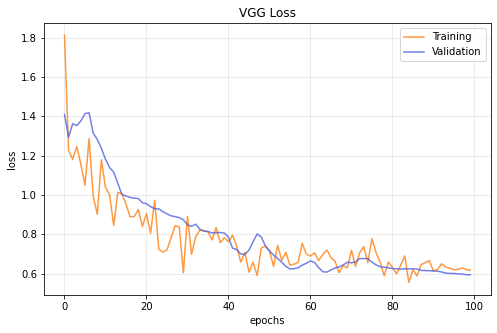

In [ ]:
# Plot the accuracy
plt.figure(figsize=(8,5))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.title(mode + ' Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

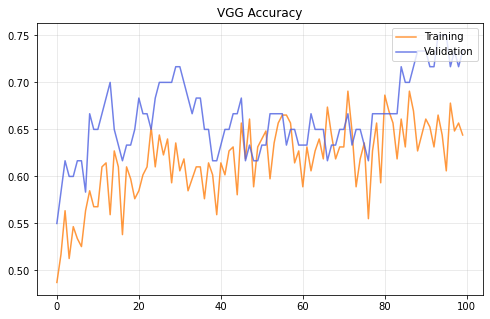

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.title(mode + ' Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

## Tensorboard

In [ ]:
%cd /gdrive/MyDrive/Colab Notebooks/AN2DL/Homework1

%load_ext tensorboard
%tensorboard --logdir results
# logdir: directory of the experiments
# --logdir ... --port 6006: default

# Model evaluation

In [ ]:
# Load a chosen model
# model = tfk.models.load_model("/kaggle/working/experiments/VGG_"+"Nov15_19-08-09"+"/base_ckpts/cp_13.ckpt",)
model = tfk.models.load_model("/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework1/experiments/VGG_Nov17_21-14-22/base_ckpts/cp_78.ckpt",)

In [ ]:
def predict(model, X):
    # # X = tf.image.resize(X, (256, 256))
    # image_array = np.reshape(X, (1, 256, 256, 3))
    # # image_array = tf.keras.preprocessing.image.img_to_array(image_array)
    #
    # out = loaded_model.predict(x=image_array / 255.)
    # # out = loaded_model.predict(image_array)
    #
    # out = tf.argmax(out, axis=-1)
    #
    # return out

    # Insert your preprocessing here

    X = np.reshape(X, (1, 96, 96, 3))
    assert X.ndim == 4

    # X = tf.keras.applications.efficientnet.preprocess_input(X)
    X = X / 255.
    # predicts = []
    # fs = [tf.image.flip_left_right, tf.image.flip_up_down, tf.image.transpose]
    # for f in fs:
    #     data = f(X)
    #     pred = model.predict(data)
    #     predicts.append(pred)
    # prediction = model.predict(X)
    # for j in range(0, len(predicts)):
    #     prediction += predicts[j]
    # prediction = prediction / (1 + len(predicts))

    prediction = model.predict(X)
    output = tf.argmax(prediction, axis=-1)

    return output

In [ ]:
a = predict(model, imgs_x[0])
a

TensorShape([1])

In [ ]:
test_gen.class_indices

{'Others': 0, 'Species1': 1}

In [ ]:
evaluation = model.evaluate(val_gen)
evaluation

5/5 [==============================] - 0s 32ms/step - loss: 0.4281 - accuracy: 0.8133


[0.4281134009361267, 0.8133333325386047]

In [ ]:
evaluation = model.evaluate(imgs_x, imgs_y)
evaluation

111/111 [==============================] - 5s 42ms/step - loss: 0.3416 - accuracy: 0.9472


[0.3416038453578949, 0.9472049474716187]

In [ ]:
valid_imgs_x[0].shape

(96, 96, 3)

In [ ]:
X = np.reshape(imgs_x, (-1, 96, 96, 3))
# predictions = model.predict(train_gen)
# output = tf.argmax(predictions, axis=-1)
# output = tf.argmax(predictions, axis=-1)
a = np.array([[0,0.1,0.2,0.3],[0.8,0.6,0.7,0.5]])
output = tf.argmax(a[:,1:], axis=-1)
# predictions[predictions>0.99] = 1
# predictions[predictions<=0.99] = 0
# predictions = np.array(predictions.T[0], dtype=int)
# predictions
output

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

In [ ]:
train_gen.y

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [ ]:
(predictions==train_gen.y)

array([False,  True,  True, False,  True,  True, False,  True,  True,
        True, False, False, False,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False,  True, False,  True,  True,  True, False,  True,
       False, False, False,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True, False, False,
        True, False,  True,  True,  True, False, False, False, False,
       False,  True, False,  True,  True, False,  True,  True, False,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True, False,  True,
       False,  True, False, False, False, False, False,  True,  True,
       False, False,  True, False,  True,  True, False, False,  True,
       False, False, False, False,  True, False,  True,  True, False,
       False, False,

In [ ]:
=out = np.where(np.any(predictions>0.1, axis=1))[0]
out

array([0, 2, 5, 9])

In [ ]:
for idx in output:
    print()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
import tensorflow.experimental.numpy as tnp

In [ ]:
a = tnp.zeros(1, dtype=tf.dtypes.int64)
len(list(a.numpy()))
a

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [ ]:
a = np.array
a.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
val_gen.y

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1])

In [ ]:
print(0 in output)

True


In [ ]:
test_gen.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
n_others = (test_gen.labels == 0).sum()
n_others

In [ ]:
n_ones = (test_gen.labels == 1).sum()
n_ones

In [ ]:
n_others/n_ones

16.85

# Model saving
The model is saved and it can be reloaded if necessary.

In [ ]:
# Save the model
model.save(mode)

In [ ]:
(test_gen.labels == 0).sum()